# 2 - Dataset Shift

## 2.1 - Baixando e importando dados

In [ ]:
# baixando o dataset para utilizar no ambiente Google Colab
!gdown --id 1iwTU12iQhT8kPPMcG9z06OvL1IJdINFv

Downloading...
From: https://drive.google.com/uc?id=1iwTU12iQhT8kPPMcG9z06OvL1IJdINFv
To: /content/train.csv.zip
1.67GB [00:13, 121MB/s]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

from sklearn.model_selection import train_test_split

In [ ]:
# importando os dados
df = pd.read_csv('train.csv.zip', compression='zip', nrows=5000000,
                   error_bad_lines=False).drop(columns='key')

## 2.2 Adicionando variável temporal

In [ ]:
%%time

print(df['pickup_datetime'].isna().sum())

df['pickup_datetime'] = df.progress_apply(lambda x: pd.to_datetime(x.pickup_datetime), axis=1)

df['weekday'] = df.progress_apply(lambda x: x.pickup_datetime.day, axis=1)
df['year'] = df.progress_apply(lambda x: x.pickup_datetime.year, axis=1)
df['month'] = df.progress_apply(lambda x: x.pickup_datetime.month, axis=1)
df['time'] = df.progress_apply(lambda x: x.pickup_datetime.hour*60 + x.pickup_datetime.minute, axis=1)
df['weekofyear'] = df.progress_apply(lambda x: x.pickup_datetime.weekofyear, axis=1)

0


100%|██████████| 3000000/3000000 [00:51<00:00, 58811.18it/s]


CPU times: user 21min 59s, sys: 16.7 s, total: 22min 16s
Wall time: 22min 10s


In [ ]:
df_train, df_test, _, _ = train_test_split(df, df.index, test_size=0.2, random_state=42)

- rodando um histograma simples das variáveis temporais não temos grandes insights, as variáveis parecem uniformemente distribuídas na nossa base.

- apenas ficamos com o alerta de que não temos 2015 completo

In [ ]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()

(Timestamp('2009-01-01 00:00:46+0000', tz='UTC'),
 Timestamp('2015-06-30 23:59:03+0000', tz='UTC'))

- uma única interessante para olhar é a variável time (tempo em minutos desde meia noite). aqui vemos um padrão com maior uso do taxi em horários específicos do dia, oque pode influenciar no preço (dependendo se temos bandeiras diferentes).

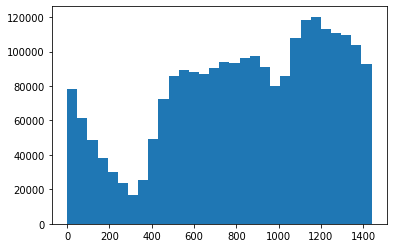

In [ ]:
plt.hist(df_train['time'], bins=30)
plt.show()

## 2.3 Análise

Para analisar mudanças temporais vamos criar um modelo que, dada variáveis que queremos estudar o comportamento, tenta prever de qual ano aquele exemplo é. Se esse modelo tem uma perfomance alta, podemos concluir que existe uma mudança temporal significativa nas variáveis observadas.

Vamos utilizar uma métrica de avaliação Ranked Probability Score (com uma ótima explicação no Desafio 2021 do Mercado Livre https://ml-challenge.mercadolibre.com/rules). Quanto menor, melhor o nosso modelo faz a tarefa de previsão.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

In [ ]:
df_aux_train = df_train.head(10000).reset_index()
df_aux_test = df_train.tail(10000).reset_index()

var_cols = ['pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

time_cols = ['weekday', 'time']

def rps_loss(y_true, y_pred):
    return ((y_true.cumsum(axis=1) - y_pred.cumsum(axis=1)).sum(axis=1)**2).mean()

In [ ]:
rps_loss(pd.get_dummies(df_aux_test['year']), np.ones((10000,7))/7)

3.5956

Primeiro, vamos analisar o comportamento temporal das variáveis explicativas.

In [ ]:
X = df_aux_train[var_cols+time_cols].fillna(0)
year = df_aux_train['year']

rfc_explicativas = RandomForestClassifier().fit(X, year)

In [ ]:
if (rfc_explicativas.classes_ == [2009, 2010, 2011, 2012, 2013, 2014, 2015]).all():
  print(rps_loss(pd.get_dummies(df_aux_test['year']), rfc_explicativas.predict_proba(df_aux_test[var_cols+time_cols].fillna(0))))
else:
  print("O classificador não está retornando ordenado, verificar.")

(pd.DataFrame(rfc_explicativas.feature_importances_, 
              index=X.columns, columns=['feature_importances'])
.sort_values(by='feature_importances', ascending=False)
)

3.435726220000015


,feature_importances
time,0.145630
pickup_latitude,0.140962
dropoff_latitude,0.140228
dropoff_longitude,0.140209
pickup_longitude,0.138913
weekday,0.115458
weekofyear,0.094555
month,0.044492
passenger_count,0.039554


Agora, vamos fazer a mesma análise olhando a variável objetivo.

In [ ]:
X = df_aux_train[['fare_amount']]
year = df_aux_train['year']

rfc_target = RandomForestClassifier(max_features=None).fit(X, year)

In [ ]:
if (rfc_target.classes_ == [2009, 2010, 2011, 2012, 2013, 2014, 2015]).all():
  print(rps_loss(pd.get_dummies(df_aux_test['year']), rfc_target.predict_proba(df_aux_test[['fare_amount']])))
else:
  print("O classificador não está retornando ordenado, verificar.")

1.7231247276339956


Olhando com mais detalhe para a relação temporal da target.

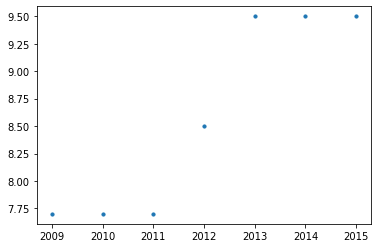

In [ ]:
x = df_train.groupby("year").fare_amount.median().sort_index()
plt.scatter(x.index, x.values, s=10)
plt.show()

Olhando mais no detalhe por ano, vemos que em 2012 temos uma quebra do padrão. Isso nos motiva a ver no mais granular de ano-mês.

In [ ]:
df_train['anomes'] = df_train.apply(lambda x: int(str(x.year)+str(x.month).zfill(2)), axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


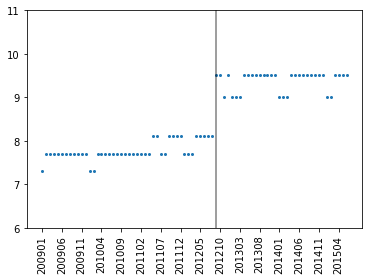

In [ ]:
x = df_train.groupby("anomes").fare_amount.median().sort_index()
plt.scatter(range(0, len(x)), x.values, s=4)
plt.xticks(range(0,78,5), x.reset_index().iloc[range(0,78,5)].anomes, rotation=90)
plt.vlines(44, 6, 11, alpha = 0.5)
# print(x.reset_index().query("anomes==201209"))
plt.ylim(6, 11)
plt.show()

Observando esses dois padrões podemos hipotetizar sobre sua motivação. Uma breve pesquisa no google já nos mostra o que aconteceu: em setembro de 2012, foi combinado um aumento no preço dos taxis. https://www.nytimes.com/2012/09/04/nyregion/new-york-taxis-to-start-charging-increased-rates.html

Para nossas análises, com a esperança de que os dados do futuro mantenham a distribuição das safras mais recentes de dados, vamos ver se dentro desse segundo padrão, os dados de anos diferentes são comparáveis. Utilizando a mesma abordagem temos:

In [ ]:
df_atual = df_train.query("anomes>=201209")

df_atual_train = df_atual.head(10000).reset_index()
df_atual_test = df_atual.tail(10000).reset_index()

In [ ]:
X = df_atual_train[['fare_amount']]
year = df_atual_train['year']

rfc_target = RandomForestClassifier(max_features=None).fit(X, year)

In [ ]:
if (rfc_target.classes_ == [2012, 2013, 2014, 2015]).all():
  print(rps_loss(pd.get_dummies(df_atual_test['year']), rfc_target.predict_proba(df_atual_test[['fare_amount']])))
else:
  print("O classificador não está retornando ordenado, verificar.")

0.810471029256531


O valor da métrica parece baixo, mas é porque mudamos o número de anos possíveis para apenas 4. Comparando com o chute uniforme, vemos que agora realmente perdemos o problema temporal escolhendo os dados apenas a partir da data estudada.

In [ ]:
rps_loss(pd.get_dummies(df_atual_test['year']), np.ones((10000,4))/4)

0.8234

No proxímo notebook vou fazer o pré-processamento das nossas variáveis.